# Eye Track, Initial Exploration

In [1]:
import json
import re
import ast
import pandas as pd
import seaborn as sb
from datetime import datetime
import time
import hypertools as hyp
import numpy as np
from matplotlib import pyplot as plt
import os

# Parse json file 

In [2]:
class parseFile():
    def __init__(self, file):
        self.file = file
    def parse(self):
        json_data = open(self.file).read()
        return(json_data)

In [4]:
newFile = parseFile('/Users/kirstenziman/Desktop/attention-memory-task/data/KIRSTEN_LAST_2018_Jul_06/KIRSTEN_LAST.json')
data = newFile.parse()

for a,b in zip(['true','false'], ['True', 'False']):
    data = data.replace(a, b)

data = data.split('\n')
data = [x for x in data if "tracker" in x]

# Prepare DataFrame

## Create DF

In [5]:
dict_list = [ast.literal_eval(x) for x in data]
dict_list = [x['values']['frame'] for x in dict_list]

df = pd.DataFrame(dict_list)

## Extract Raw Right and Left Eye Values; Make average col

In [6]:
for eye in ['righteye','lefteye']:
    for coord in ['x','y']:
        df[coord+'Raw_'+eye] = [df[eye][row]['raw'][coord] for row in df.index.values]
        
df['av_x_coord'] = df[['xRaw_righteye', 'xRaw_lefteye']].mean(axis=1)
df['av_y_coord'] = df[['yRaw_righteye', 'yRaw_lefteye']].mean(axis=1)

## Switch timestamps to gmtime

In [7]:
df['timestamp']=[time.mktime(time.strptime(x[:-4], "%Y-%m-%d %H:%M:%S"))+float(x[-4:]) for x in df['timestamp']]

In [8]:
df.head(2)

,avg,fix,lefteye,raw,righteye,state,time,timestamp,xRaw_righteye,yRaw_righteye,xRaw_lefteye,yRaw_lefteye,av_x_coord,av_y_coord
0,"{'x': 1177.7775, 'y': 402.0335}",True,"{'avg': {'x': 1182.5292, 'y': 376.8414}, 'pcen...","{'x': 1170.5952, 'y': 407.361}","{'avg': {'x': 1170.5178, 'y': 420.53}, 'pcente...",7,831777290,1.530914e+09,1173.1147,427.5268,1168.0756,387.1952,1170.59515,407.3610
1,"{'x': 1176.5497, 'y': 401.9254}",True,"{'avg': {'x': 910.6056, 'y': 558.9542}, 'pcent...","{'x': 891.8802, 'y': 517.5296}","{'avg': {'x': 873.1549, 'y': 476.105}, 'pcente...",7,831777324,1.530914e+09,873.1549,476.1050,910.6056,558.9542,891.88025,517.5296


# Plot Eye Track Data from Presentation Runs only

In [9]:
def pres_gaze(subdir, eye_df):
    '''
    input: subject's experiment df and eye track df
    output: list of eye tracking df's, one for each presentation trial 
    '''
    
    pres_gaze = []
    
    for f in os.listdir(subdir):
        if 'pres' in f:
            pres_df = pd.read_csv(subdir+'/'+f)
            start = pres_df['Stimulus Start'][0]
            end = pres_df['Stimulus End'][9]#+pres_df['Attention Reaction Time (s)'][9]
            pres_gaze.append(eye_df.loc[(eye_df['timestamp']>start) & (eye_df['timestamp']<end)])
            
    return(pres_gaze)

def gaze_plot(df_list, plot=True):

    fig = plt.figure()
    ax1 = fig.add_subplot(111)

    # for each possible number rating
    for x in df_list:
        ax1.plot(x['av_x_coord'], x['av_y_coord'], '.')

    if plot:
        # plt.legend(loc='upper left');
        plt.ylim(0, 1152)
        plt.xlim(0, 2048)
        plt.gca().set_aspect('equal', adjustable='box')
        plt.show()
        
    
    

# Average gaze points (pres runs)

the blob where the vast majority of gazepoints lie (approx x=1,000) shows the shape I would expect-- roughly most gaze points at center, with the occasional right/left deviation (I was pretty tired when I ran myself here, probably would have been much better otherwise). It doesn't seem crazy that I might have at some point glanced to the left of the screen, but the line at x=500 seems really strange. (Points were showing colored by run, but now are all red... *sigh)

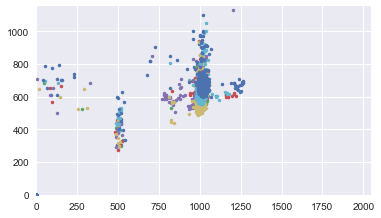

In [13]:
subdir = '/Users/kirstenziman/Desktop/attention-memory-task/data/KIRSTEN_LAST_2018_Jul_06/run_data'
df_list = pres_gaze(subdir, df)
gaze_plot(df_list)

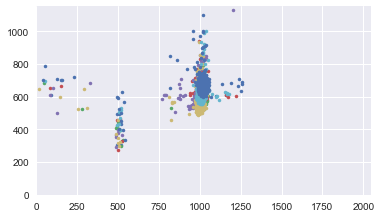

In [14]:
df_fix = [ x[x['fix']==True] for x in pres_gaze(subdir, df)]
gaze_plot(df_fix)

In [15]:
#hyp.plot(df[['xRaw_righteye', 'yRaw_righteye']][0:1000])